In [36]:
# experiment tracker
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../experiment-impact-tracker/')

from experiment_impact_tracker.data_interface import DataInterface
from experiment_impact_tracker.data_utils import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### Notes
### mgz vs nii files seem to huge FLOP difference during setup

In [69]:
def get_tracker_data(experiment_name, logdir, use_cuda):
    # impact tracker log
    tracker_df =  load_data_into_frame(logdir)

    # papi log
    compute_flops_csv = logdir + 'compute_costs_flop.csv'
    flops_df = pd.read_csv(compute_flops_csv)
    flops_df['experiment_name'] = experiment_name

    if use_cuda:
        power_df = tracker_df[0][['timestamp','rapl_power_draw_absolute','rapl_estimated_attributable_power_draw','nvidia_draw_absolute','nvidia_estimated_attributable_power_draw']]
        power_df['total_attributable_power_draw'] = power_df['rapl_estimated_attributable_power_draw'] + power_df['nvidia_estimated_attributable_power_draw']

    else:
        power_df = tracker_df[0][['timestamp','rapl_power_draw_absolute','rapl_estimated_attributable_power_draw']]
        power_df['total_attributable_power_draw'] = power_df['rapl_estimated_attributable_power_draw']
        
    # start time from 0
    power_df['timestamp'] = power_df['timestamp'] - power_df['timestamp'][0]
    power_df['experiment_name'] = experiment_name

    
    flops_df['start_time'] = flops_df['start_time'] - flops_df['start_time'][0]

    # Aggregate power draws per epoch for each papi context calculation (i.e. setup, axial, aggr etc))
    epoch_power_draw_list = []
    epoch_timestamps = list(flops_df['start_time'].values[1:]) + [power_df['timestamp'].values[-1]]
    
    for e, epoch in enumerate(epoch_timestamps):
        epoch_power_draw = power_df[power_df['timestamp'] < epoch]['total_attributable_power_draw'].sum() # this is sum upto the epoch (not interval)
        if e == 0:
            epoch_power_draw_list.append(epoch_power_draw)  
        else:
            epoch_power_draw_list.append(epoch_power_draw - epoch_power_draw_list[e-1]) #Subtracting previous stage power-draw 

    flops_df['epoch_power_draw'] = epoch_power_draw_list

    data_interface = DataInterface([logdir])
    total_power = data_interface.total_power
    total_carbon = data_interface.kg_carbon
    PUE = data_interface.PUE
    total_duration = flops_df['duration'].sum()/3600

    tracker_summary_df = pd.DataFrame(columns=['experiment_name','total_power','total_carbon','PUE','total_duration'])
    tracker_summary_df.loc[0] = [experiment_name,total_power,total_carbon,PUE,total_duration]
    return power_df, flops_df, tracker_summary_df
 



In [70]:
experiment_dict = {'local_cpu':('./logs/track_sub_0062_benchmark/',False), 
                   'CC_cpu':('./logs/CC_cpu_test/',False),
                   'CC_gpu':('./logs/CC_gpu_test/',True)}

power_df_concat = pd.DataFrame()
flops_df_concat = pd.DataFrame()
tracker_summary_df_concat = pd.DataFrame()

for k,v in experiment_dict.items():
    power_df, flops_df, tracker_summary_df = get_tracker_data(k, v[0], v[1])
    power_df_concat = power_df_concat.append(power_df)
    flops_df_concat = flops_df_concat.append(flops_df)
    tracker_summary_df_concat = tracker_summary_df_concat.append(tracker_summary_df)


7 7
5 5
5 5


In [71]:
flops_df_concat

,Unnamed: 0,task,start_time,duration,DP,MAC,params,experiment_name,epoch_power_draw
0,0,setup,0.000000,0.694400,779,0,0,local_cpu,28.173664
1,1,axial,0.698135,3748.829273,26340,0,0,local_cpu,13009.639636
2,2,Coronal,3749.532665,3582.418907,26206,0,0,local_cpu,12463.668780
3,3,Sagittal,7331.956060,3166.592272,26822,0,0,local_cpu,23957.419116
4,4,aggregate,10498.555964,7.712187,3761767767,0,0,local_cpu,12471.398579
5,5,cleanup,10506.271594,0.000022,1,0,0,local_cpu,23957.419116
6,6,save,10506.274534,0.379586,121,0,0,local_cpu,12463.668780
0,0,setup,0.000000,2.287050,748428232,0,0,CC_cpu,29.388791
1,1,axial,2.292166,1206.855055,21715,0,0,CC_cpu,29498.230459
2,2,Coronal,1209.151849,1233.741771,21725,0,0,CC_cpu,27237.954776


## Plots
### Summary power

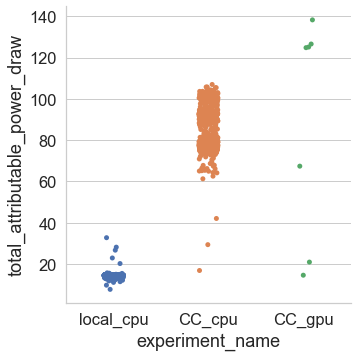

In [72]:
plot_df = power_df_concat.copy()

sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='total_attributable_power_draw', x='experiment_name', data=plot_df, kind='strip')


### Power trace

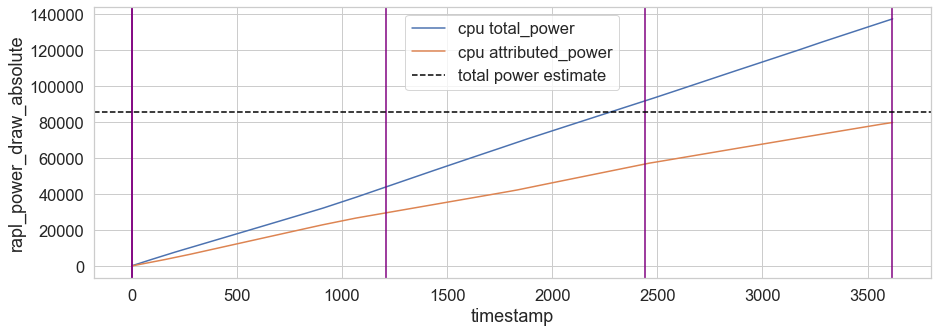

In [5]:
plot_df = power_df_concat.copy()

sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,5),sharex=False,sharey=False)

    g = sns.lineplot(plot_df['timestamp'],plot_df['rapl_power_draw_absolute'].cumsum(),label='cpu experiment_name')
    g = sns.lineplot(plot_df['timestamp'],plot_df['rapl_estimated_attributable_power_draw'].cumsum(),label='cpu attributed_power')

    if use_cuda:
        g = sns.lineplot(plot_df['timestamp'],plot_df['nvidia_draw_absolute'].cumsum(),label='gpu total_power')
        g = sns.lineplot(plot_df['timestamp'],plot_df['nvidia_estimated_attributable_power_draw'].cumsum(),label='cpu attributed_power')

    for e in epochs:
        g = plt.axvline(e, linestyle='-',c='purple')
    
    g = plt.axhline(1000000*total_power/PUE, linestyle='--',c='black',label='total power estimate')
    
    plt.legend()


In [17]:
# experiment tracker
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../experiment-impact-tracker/')

from experiment_impact_tracker.compute_tracker import ImpactTracker
import tempfile
import time

def func1():
    count = 0
    for i in range(100):
        count += i
    return count

def func2():
    count = 0
    for i in range(100):
        count += i**2
    return count

In [2]:
experiment1 = tempfile.mkdtemp()
experiment2 = tempfile.mkdtemp()

print('Tracker 1')
tracker1  = ImpactTracker(experiment1)
print(tracker1.launched)
with tracker1:
    func1()
    print(tracker1.launched)

time.sleep(1)
print('Tracker 2')
tracker2  = ImpactTracker(experiment2)
print(tracker2.launched)
with tracker2:
    print('Starting context')
    print(tracker2.launched)
    print('Starting func2')
    func2()
    print(tracker2.launched)

INFO:Gathering system info for reproducibility...
Tracker 1
INFO:Requested http://ipinfo.io/json
INFO:Done initial setup and information gathering...
False
INFO:Requesting thread shutdown.
INFO:Starting process to monitor power
True
INFO:Starting - Logging final info.
INFO:Done - Logging final info.
INFO:Gathering system info for reproducibility...
Tracker 2
INFO:Done initial setup and information gathering...
experiment_impact_tracker.compute_tracker.ImpactTracker - ERROR - Encountered exception when launching power monitor thread.
experiment_impact_tracker.compute_tracker.ImpactTracker - ERROR - Encountered exception when launching power monitor thread.
ERROR:Encountered exception when launching power monitor thread.
--- Logging error ---
Traceback (most recent call last):
  File "../../experiment-impact-tracker/experiment_impact_tracker/compute_tracker.py", line 293, in launch_impact_monitor
    multiprocessing.set_start_method("fork")
  File "/home/nikhil/anaconda3/envs/green_compu

RuntimeError: context has already been set

In [48]:
from experiment_impact_tracker.emissions.get_region_metrics import \
    get_current_region_info_cached, get_current_location

In [46]:
region_info = get_current_region_info_cached()
region_info

({'type': 'Feature',
  'geometry': <shapely.geometry.multipolygon.MultiPolygon at 0x7fcb0ff87d50>,
  'properties': {'zoneName': 'CA-ON'},
  'id': 'CA-ON'},
 {'_source': 'https://github.com/tmrowco/electricitymap-contrib/blob/master/config/co2eq_parameters.json (ElectricityMap Average, 2019)',
  'carbonIntensity': 45.21034939608702,
  'fossilFuelRatio': 0.06218982738518038,
  'renewableRatio': 0.32982581430396574})

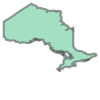

In [47]:
region_info[0]['geometry']

In [50]:
get_current_location()

INFO:Requested http://ipinfo.io/json


(43.5789, -79.6583)